# MOVIE RATING ANALYSIS
This is just basic data exploration 

## Import the required modules

In [35]:
from timeit import default_timer
start = default_timer()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Load required files
For first time data load:
1. Load original CSV files.
2. Sort by movieId (main key we'll be using) and reset the indices.
3. Split title and year into separate columns. Convert year to datetime.
4. Categorize genres properly: split strings into boolean columns per genre.
5. Modify the rating timestamp: from universal seconds to datetime year.
6. Check for NaN values. Clean (delete rows) if % of NaN values is small.

In [32]:
st = default_timer()

# First time data load.
movies = pd.read_csv('input/movies.csv')
ratings = pd.read_csv('input/ratings.csv')
    
# Organise a bit and store into feather-format
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(ratings.dtypes)

# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)
    
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object
Number of movies Null values:  13
Number of ratings Null values:  0
Elapsed time(sec):  0.34


## Explore the data with some basic plots  <br>

<font color=darkblue>**PLOT**: Number of movies per year. <br/> </font>
<font color=green>**INSIGHT**: Number of movies released per year increasing almost exponentially until 2009, then flattening and dropping signifincantly in 2014. No ratings before 1995, likely to do with this website being on the internet.</font>

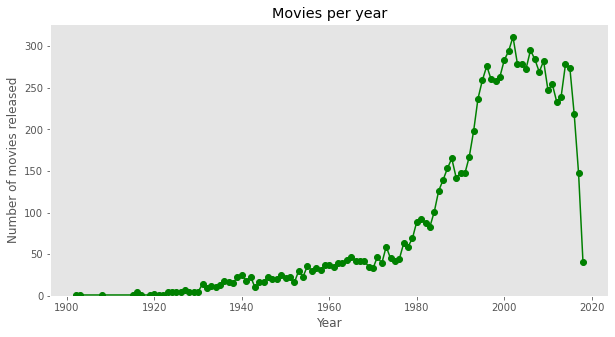

Elapsed time(sec):  0.13


In [19]:
st = default_timer()

# take a smaller slice
dftmp = movies[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released')
plt.title('Movies per year')
plt.show()

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT**: Cumulative number of movies, in total and per genre. <br/> </font>
<font color=green>**INSIGHT**: On average, movies are categorized into 2 genres. Comedy and Drama are the top genres used.</font>

<Figure size 720x360 with 0 Axes>

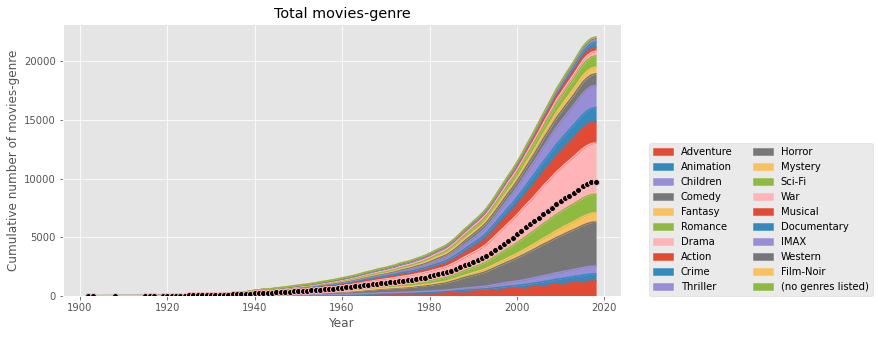

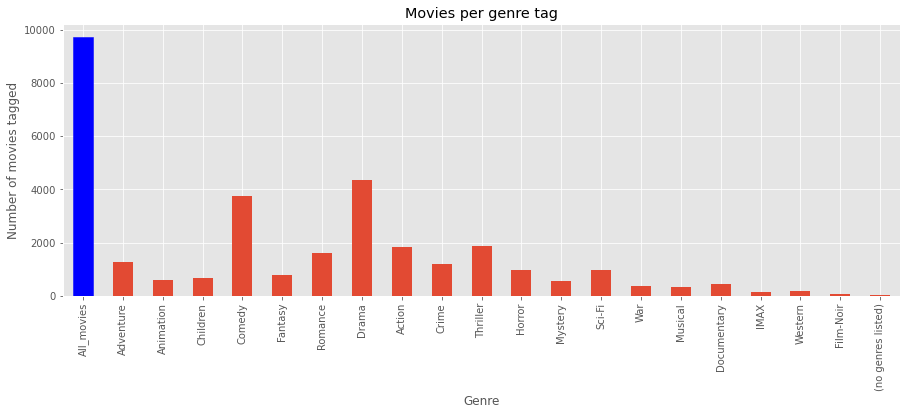

Elapsed time(sec):  0.56


In [21]:
st = default_timer()

plt.figure(figsize=(10,5))
dftmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.movieId.nunique().cumsum()})
# Plot histogram for each individual genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

# Housekeeping
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT**: Distributions by genre, on top of total rating distribution. <br/> </font>
<font color=green>**INSIGHT**: All genres show a similar pattern (bell curve), except perhaps Horror movies which are a bit skewed to the left (poorer ratings)</font>

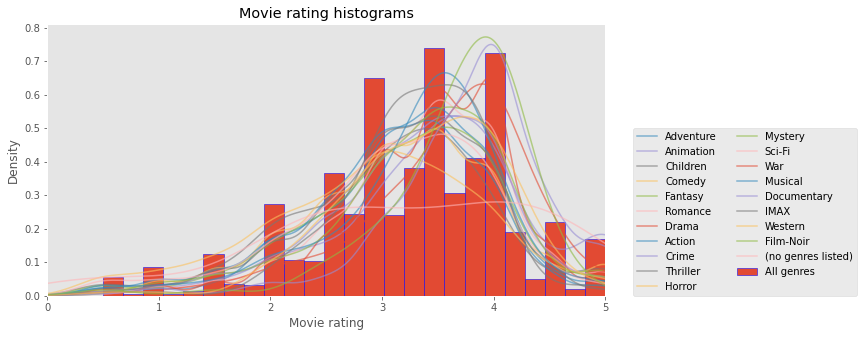

Elapsed time(sec):  0.76


In [37]:
st = default_timer()

dftmp = ratings[['movieId','rating']].groupby('movieId').mean()

# Initialize empty list to capture basic stats by gere
rating_stats = []
# Plot general histogram of all ratings
dftmp.hist(bins=25, grid=False, edgecolor='b', density=True, label ='All genres', figsize=(10,5))
# Plot histograms (kde lines for better visibility) per genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]==True]
    dftmp = ratings[ratings.set_index('movieId').index.isin(dftmp.set_index('movieId').index)]
    dftmp = dftmp[['movieId','rating']].groupby('movieId').mean()
    dftmp.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre)
    avg = dftmp.rating.mean()
    std = dftmp.rating.std()
    rating_stats.append((genre, avg, std))
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

# Housekeeping
%reset_selective -f (^avg$|^dftmp$|^genre$|^std$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT**: Average rating for all individual movies. <br>
<font color=green>**INSIGHT**: Especially after 1970, it seems there are more lower ratings, but also more higher (4.5-5.0). Not many insights from this plot.</font>

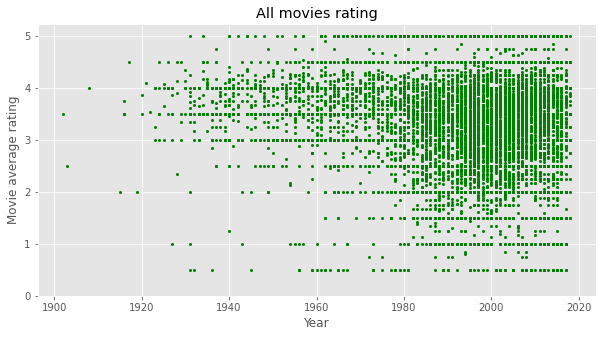

Elapsed time(sec):  0.13


In [38]:
st = default_timer()

dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)
plt.xlabel('Year')
plt.ylabel('Movie average rating')
plt.title('All movies rating')
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT**: Average rating for all movies in each year, and also per genre. <br>
<font color=green>**INSIGHT**: Slight decline in average movie ratings after 1960, but still remains above 3. Range quite narrow, except for a few outliers.</font>

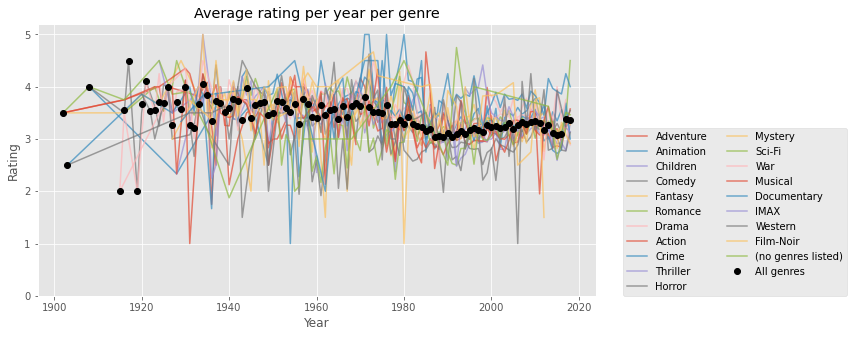

Elapsed time(sec):  0.45


In [39]:
st = default_timer()

plt.figure(figsize=(10,5))
# For each genre
for genre in genres_unique.genre:
    # Select only movies matching current genre. Pick only movieId (as index) and year.
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    # Selects ratings, with movieId as index. Select only movies that match also the previous step. Join both.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # Now we have a df of movieId, year and multiple ratings. Group by year and compute the average rating.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7)

# For all genres
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='black')

plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year per genre')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT**: Average ratings per user. <br>
<font color=green>**INSIGHT**: Users have a positive bias in general, with roughly 95% of their average ratings above the mid-point of 2.5.</font>

<ipython-input-40-9d2b40dc7e04>:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  values, base = np.histogram(dftmp, bins=40, normed=True)


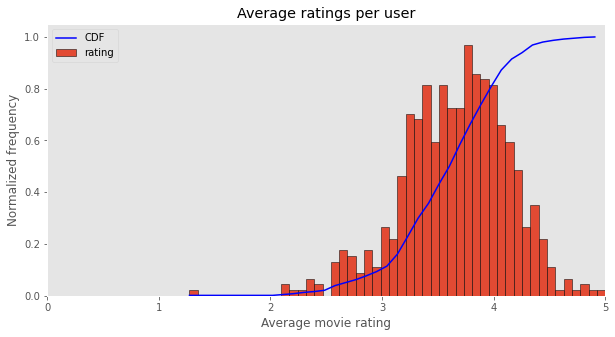

Elapsed time(sec):  0.21


In [40]:
st = default_timer()

dftmp = ratings[['userId','rating']].groupby('userId').mean()
# Plot histogram
dftmp.plot(kind='hist', bins=50, grid=0, density=True, edgecolor='black', figsize=(10,5))
# Plot cumulative function on top (couldn't do any other way)
# evaluate the histogram
values, base = np.histogram(dftmp, bins=40, normed=True)
# evaluate the cumulative (multiply by the average distance between points in the x-axis to get UNIT area)
cumulative = np.cumsum(values) * np.diff(base).mean()
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue', label='CDF')
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Average movie rating')
plt.ylabel ('Normalized frequency')
plt.title ('Average ratings per user')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^base$|^cumulative$|^values$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT**: Ratings per user.<br>
<font color=green>**INSIGHT**: As expected, exponentially declining function, with no users with less than 20 ratings given, and some outliers with 7.5k and 9.2k ratings.</font>

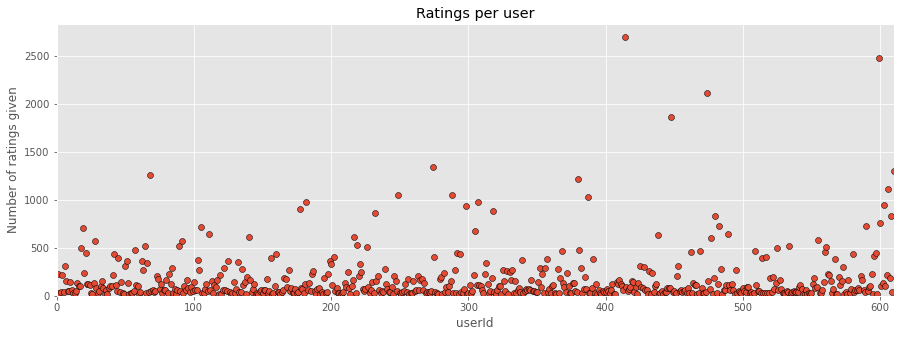

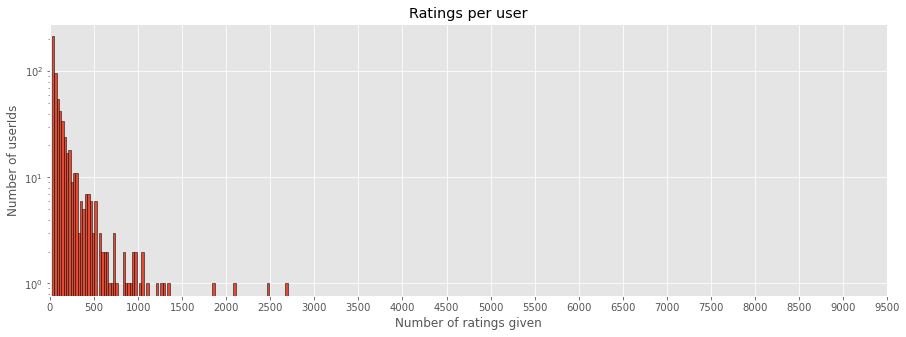

Elapsed time(sec):  0.61


In [42]:
st = default_timer()

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('userId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,len(dftmp.index))
plt.ylim(0,)
plt.title('Ratings per user')
plt.xlabel('userId')
plt.ylabel('Number of ratings given')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per user')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of userIds')
plt.xlim(0,)
plt.xticks(np.arange(0,10000,500))
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT**: Ratings per movie.<br>

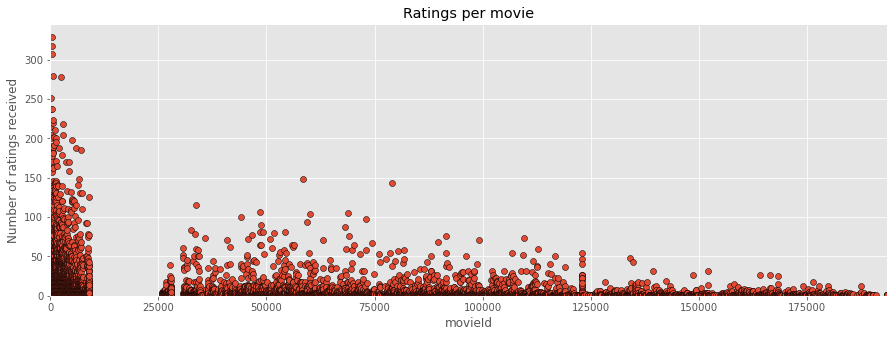

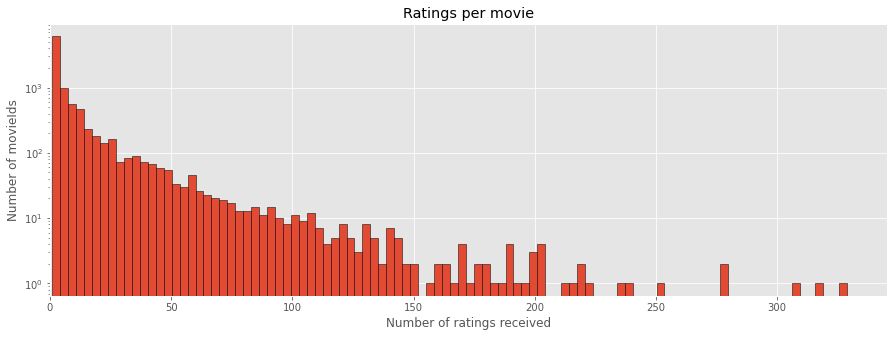

Elapsed time(sec):  0.63


In [43]:
st = default_timer()

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()


# Housekeeping
%reset_selective -f (^dftmp$|^tmp$|^best$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

### Compute total runtime

In [44]:
runtime = default_timer() - start
print ("Elapsed time(sec): ", round(runtime,2))


Elapsed time(sec):  167.94


In [45]:
%whos

Variable        Type                          Data/Info
-------------------------------------------------------
X               ndarray                       1: 1 elems, type `int64`, 8 bytes
Xi              ndarray                       106x1: 106 elems, type `int64`, 848 bytes
Y               ndarray                       106: 106 elems, type `float64`, 848 bytes
Yi              ndarray                       106x1: 106 elems, type `float64`, 848 bytes
Z               ndarray                       106x1: 106 elems, type `float64`, 848 bytes
Zcap            ndarray                       106x1: 106 elems, type `float64`, 848 bytes
ax              AxesSubplot                   AxesSubplot(0.125,0.536818;0.352273x0.343182)
ax1             AxesSubplot                   AxesSubplot(0.125,0.125;0.775x0.755)
ax2             AxesSubplot                   AxesSubplot(0.125,0.125;0.775x0.755)
axs             ndarray                       2x2: 4 elems, type `object`, 32 bytes
cutoff          list